#Assignment Part 2 '**Detective Vision**'

Detective Vision—the security firm that safeguards some of the city's most important buildings. Recently, one of our high-profile clients reported a series of suspicious activities around their building and parking lot. The client is particularly concerned about certain vehicles that have been seen entering the premises at odd hours.

Your mission is to develop a **Streamlit** application that can quickly identify any car by its **license plate number**.

A user can input any car license number into the Streamlit window, and the output should be the actual car image with the timestamp image indicating when that car enters the building (which is the timestamp of data entry in the database).

Your application could be the key to solving this mystery and ensuring the safety of the building's occupants.

# Setup and Data Collection

### Environment Setup:

Load the following tools into your Python environment: OpenCV, Tesseract OCR, NumPy, and Pandas.
Ensure that each library is fully operational and ready for the mission's tasks ahead.

### Load Data:

You can use the images dataset provided in car_images folder, which contains images with clear views of license plates.
Ensure that this data is correctly loaded and accessible within your environment.

In [142]:
#Environment Setup
import cv2
import pytesseract
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import ultralytics
from ultralytics import YOLO
import statistics as st

os.environ['TESSDATA_PREFIX'] = '/opt/homebrew/Cellar/tesseract/5.4.1/share/tessdata/'
os.environ['PATH'] += os.pathsep + '/opt/homebrew/bin'
pytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/bin/tesseract'  


In [143]:
image_extensions = ('.jpg', '.jpeg', '.png')

images = []
image_filenames = []

for file in os.listdir('car_images'):
    if file.lower().endswith(image_extensions):
        img_path = os.path.join('car_images', file)
        img = cv2.imread(img_path)
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img_rgb)
            image_filenames.append(file)
        else:
            print(f"Warning: Unable to read the image file '{file}'. It may be corrupted or in an unsupported format.")

df_images = pd.DataFrame({
    'filename': image_filenames,
    'image': images
})

display(df_images.head())

,filename,image
0,toyota-vitz-2007-96143950.jpg,"[[[38, 33, 30], [36, 31, 28], [34, 29, 26], [3..."
1,tn_toyota-fortuner-2-8-sigma-2022-96143593.jpg,"[[[5, 4, 12], [3, 2, 8], [3, 0, 2], [12, 7, 4]..."
2,2024-01-30_17-41.png,"[[[85, 75, 70], [92, 82, 77], [100, 88, 84], [..."
3,toyota-vitz-2007-96143941.jpg,"[[[42, 43, 27], [45, 46, 28], [57, 58, 40], [6..."
4,2024-01-30_18-54.png,"[[[31, 27, 24], [26, 22, 21], [23, 20, 19], [2..."


In [144]:
len(df_images)

9

#  License Plate Detection: 10 Marks
Now, it's time to dive deeper into the heart of the operation. Your task is to detect and isolate the license plates from the images provided, ensuring that only the most relevant information is extracted for further analysis.

### Plate Detection:

Identify and isolate potential license plate regions from the images.

Implement method for detecting license plates, exploring detection techniques such as Yolo.

In [145]:
model_path = 'license_plate_detector.pt'
yolo_model = YOLO(model_path)


0: 288x640 1 license_plate, 41.6ms
Speed: 1.1ms preprocess, 41.6ms inference, 0.3ms postprocess per image at shape (1, 3, 288, 640)

0: 480x640 1 license_plate, 53.4ms
Speed: 1.0ms preprocess, 53.4ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 608x640 1 license_plate, 69.9ms
Speed: 2.4ms preprocess, 69.9ms inference, 0.3ms postprocess per image at shape (1, 3, 608, 640)

0: 288x640 1 license_plate, 73.2ms
Speed: 1.0ms preprocess, 73.2ms inference, 0.3ms postprocess per image at shape (1, 3, 288, 640)

0: 576x640 1 license_plate, 67.2ms
Speed: 1.9ms preprocess, 67.2ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)

0: 640x384 1 license_plate, 45.9ms
Speed: 1.0ms preprocess, 45.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 608x640 1 license_plate, 72.1ms
Speed: 1.5ms preprocess, 72.1ms inference, 0.3ms postprocess per image at shape (1, 3, 608, 640)

0: 640x288 1 license_plate, 37.6ms
Speed: 1.6ms preprocess, 37.6ms i

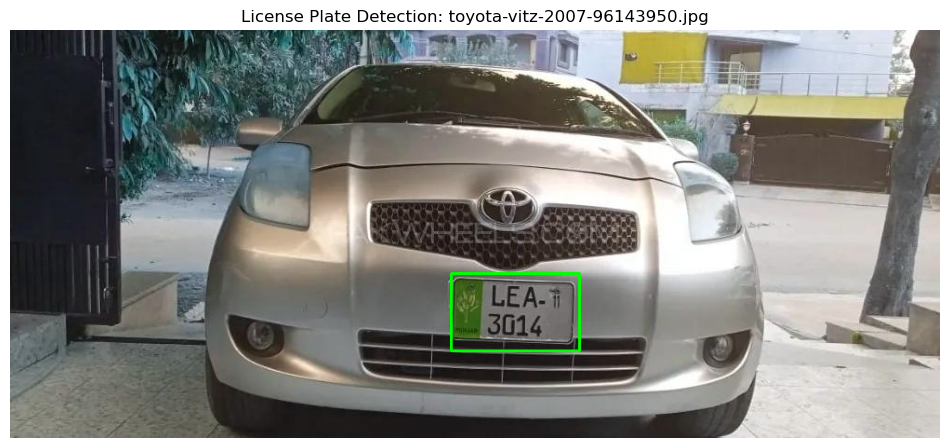

In [148]:
def detect_license_plate(image, save_output=False, output_path='output.jpg'):

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = yolo_model(image_rgb)
    
    for result in results:
        boxes = result.boxes
    
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            class_id = int(box.cls[0].cpu().numpy())
            label = yolo_model.model.names[class_id]
    
            if label.lower() == 'license_plate':
                cv2.rectangle(image_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    
    if save_output:
        output_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
        cv2.imwrite(output_path, output_image)
    
    return image_rgb

detected_images_list = []

for index, row in df_images.iterrows():
    image = row['image']
    image_file = row['filename'] 
    
    detected_image = detect_license_plate(image, save_output=False)
    
    if detected_image is not None:
        detected_images_list.append({
            'filename': image_file,
            'detected_image': detected_image
        })

if detected_images_list:
    plt.figure(figsize=(12, 8))
    plt.imshow(detected_images_list[0]['detected_image'])
    plt.axis('off')
    plt.title(f"License Plate Detection: {detected_images_list[0]['filename']}")
    plt.show()

In [149]:
def crop_image(image, zoom_factor=0.2):

    results = yolo_model(image)
    cropped_plates = []
    
    for result in results:
        boxes = result.boxes
    
        for box in boxes:

            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            class_id = int(box.cls[0].cpu().numpy())
            label = yolo_model.model.names[class_id]
    
            if label.lower() == 'license_plate':

                width = x2 - x1
                height = y2 - y1
                
                new_x1 = max(0, x1 + int(zoom_factor * width))
                new_y1 = max(0, y1 + int(zoom_factor * height))
                new_x2 = min(image.shape[1], x2 - int(zoom_factor * width))
                new_y2 = min(image.shape[0], y2 - int(zoom_factor * height))
                
                plate_img = image[new_y1:new_y2, new_x1:new_x2]
                cropped_plates.append(plate_img)
    
    return cropped_plates


0: 608x640 1 license_plate, 93.7ms
Speed: 27.0ms preprocess, 93.7ms inference, 0.3ms postprocess per image at shape (1, 3, 608, 640)


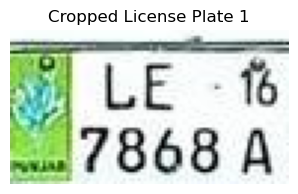

In [150]:
cropped_license_plate = crop_image(detected_image)

for idx, plate in enumerate(cropped_license_plate):
    plt.figure(figsize=(4, 2))
    plt.imshow(plate)
    plt.axis('off')
    plt.title(f'Cropped License Plate {idx+1}')
    plt.show()

In [151]:
len(detected_images_list)

9


0: 288x640 1 license_plate, 88.6ms
Speed: 2.1ms preprocess, 88.6ms inference, 0.3ms postprocess per image at shape (1, 3, 288, 640)

0: 480x640 1 license_plate, 63.2ms
Speed: 1.3ms preprocess, 63.2ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 608x640 1 license_plate, 80.5ms
Speed: 2.5ms preprocess, 80.5ms inference, 0.4ms postprocess per image at shape (1, 3, 608, 640)

0: 288x640 1 license_plate, 37.4ms
Speed: 1.6ms preprocess, 37.4ms inference, 0.3ms postprocess per image at shape (1, 3, 288, 640)

0: 576x640 1 license_plate, 67.3ms
Speed: 1.7ms preprocess, 67.3ms inference, 0.3ms postprocess per image at shape (1, 3, 576, 640)

0: 640x384 1 license_plate, 49.1ms
Speed: 1.5ms preprocess, 49.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 608x640 1 license_plate, 66.4ms
Speed: 2.0ms preprocess, 66.4ms inference, 0.3ms postprocess per image at shape (1, 3, 608, 640)

0: 640x288 1 license_plate, 41.4ms
Speed: 1.6ms preprocess, 41.4ms i

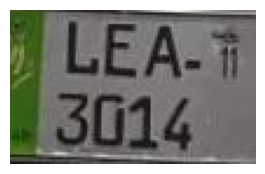

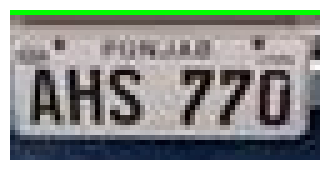

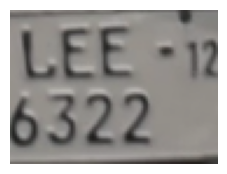

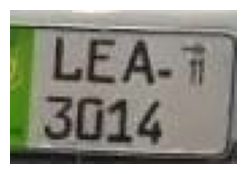

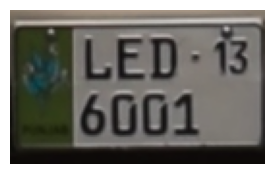

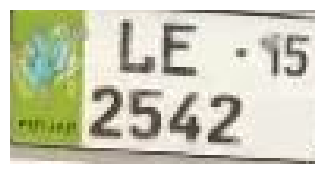

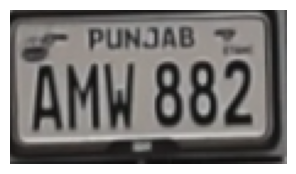

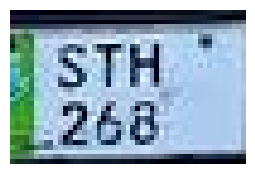

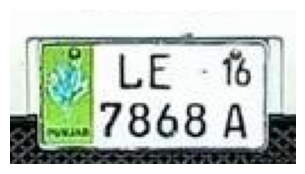

In [152]:
cropped_set = []

for detections in detected_images_list:
    image = detections['detected_image']
    cropped_plates = crop_image(image, zoom_factor=0.1)
    
    for idx, plate in enumerate(cropped_plates):
        cropped_set.append({
            'filename': detections['filename'],
            'plate': plate
        })

for idx, plate in enumerate(cropped_set):
    plt.figure(figsize=(4, 2))
    plt.imshow(plate['plate'])
    plt.axis('off')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.show()

In [153]:
len(cropped_set)

9

# Character Recognition: 15 Marks

With the license plates now isolated, you’re entering the critical phase of the operation. Your mission is to extract the characters from these plates and convert them into readable text. This will require precision and adaptability, as the plates may vary in font and size.

### Character Segmentation:

Break down the detected license plates into individual characters.

**Tasks:**
Segment the detected license plate regions into distinct characters, ensuring that each letter and number is isolated.
Handle variations in fonts and sizes by implementing adaptive thresholding techniques to achieve consistent segmentation results, regardless of plate design.

**Optical Character Recognition (OCR):**

Convert segmented characters into text using a trained convolutional neural network.

**Tasks:**
Utilize the CNN classifier model of **Part 1** to classifiy character of number plate.
Implement error correction mechanisms to address potential misrecognitions.


In [154]:
cropped_lps = [plate['plate'] for plate in cropped_set]

print(len(cropped_lps))

for lp in cropped_lps:
    print(lp.shape)

9
(66, 105, 3)
(30, 62, 3)
(66, 89, 3)
(57, 84, 3)
(80, 132, 3)
(49, 97, 3)
(63, 113, 3)
(32, 49, 3)
(68, 126, 3)


In [155]:
crop_mat = [[16, 15, 3, 3], [3, 5, 10, 5], [0, 15, 4, 4], [ 12, 25, 9, 6], [34, 30, 10, 10], [25, 20, 2, 5], [5, 10, 18, 12], [7, 9, 4, 3], [40, 35, 16, 10]]

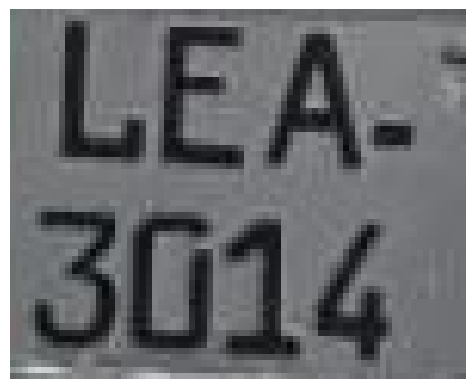

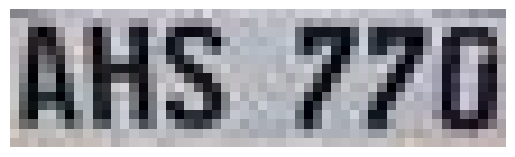

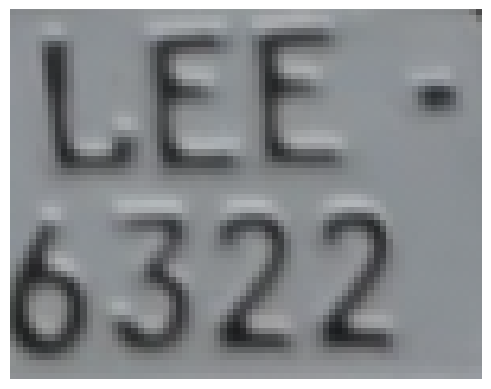

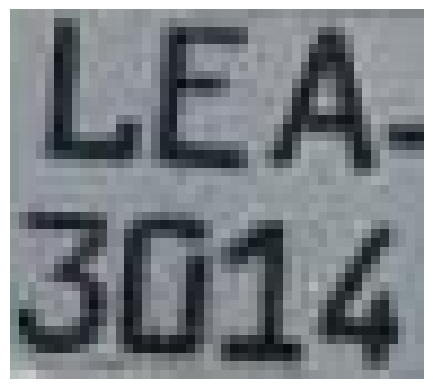

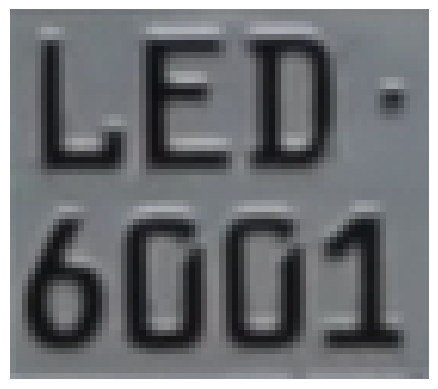

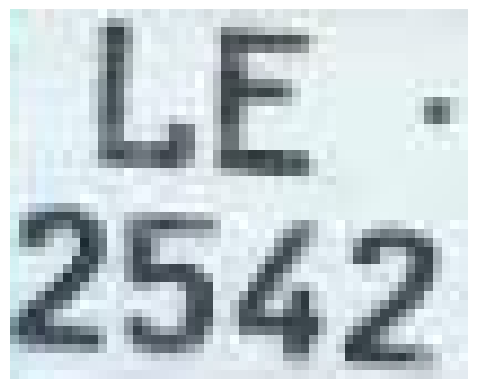

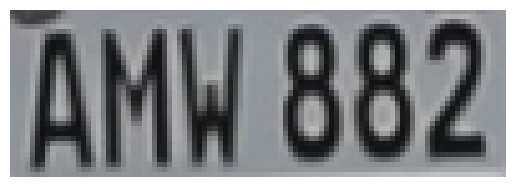

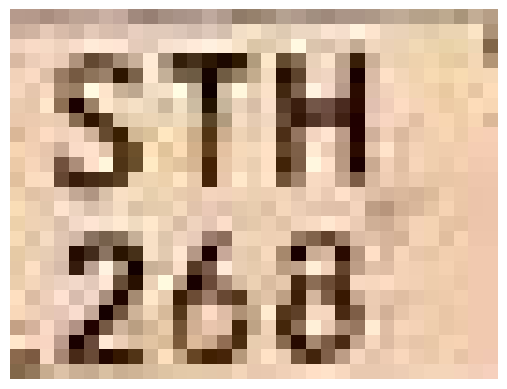

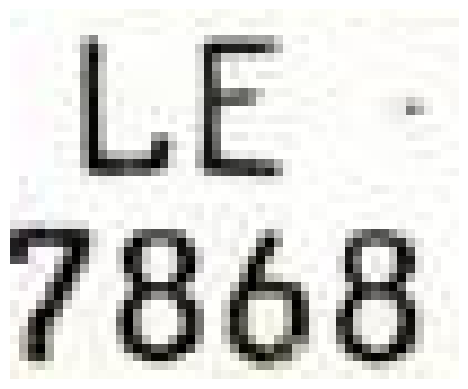

In [156]:
def crop_adjustment(image, crop_left, crop_right, crop_top, crop_bottom):
    height, width = image.shape[:2]
    cropped_image = image[crop_top:height - crop_bottom, crop_left:width - crop_right]

    plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
    return cropped_image

x0 = crop_adjustment(cropped_lps[0], crop_mat[0][0], crop_mat[0][1], crop_mat[0][2], crop_mat[0][3])
x1 = crop_adjustment(cropped_lps[1], crop_mat[1][0], crop_mat[1][1], crop_mat[1][2], crop_mat[1][3])
x2 = crop_adjustment(cropped_lps[2], crop_mat[2][0], crop_mat[2][1], crop_mat[2][2], crop_mat[2][3])
x3 = crop_adjustment(cropped_lps[3], crop_mat[3][0], crop_mat[3][1], crop_mat[3][2], crop_mat[3][3])
x4 = crop_adjustment(cropped_lps[4], crop_mat[4][0], crop_mat[4][1], crop_mat[4][2], crop_mat[4][3])
x5 = crop_adjustment(cropped_lps[5], crop_mat[5][0], crop_mat[5][1], crop_mat[5][2], crop_mat[5][3])
x6 = crop_adjustment(cropped_lps[6], crop_mat[6][0], crop_mat[6][1], crop_mat[6][2], crop_mat[6][3])
x7 = crop_adjustment(cropped_lps[7], crop_mat[7][0], crop_mat[7][1], crop_mat[7][2], crop_mat[7][3])
x8 = crop_adjustment(cropped_lps[8], crop_mat[8][0], crop_mat[8][1], crop_mat[8][2], crop_mat[8][3])

x = [x0, x1, x2, x3, x4, x5, x6, x7, x8]

In [157]:
for lp in x:
    print(lp.shape)

(60, 74, 3)
(15, 54, 3)
(58, 74, 3)
(42, 47, 3)
(60, 68, 3)
(42, 52, 3)
(33, 98, 3)
(25, 33, 3)
(42, 51, 3)


In [158]:
def find_contours(dimensions, img):
    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 15 contours for license plate characters
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    x_cntr_list = []
    img_res = []
    
    # Find image dimensions
    img_height = img.shape[0]
    bottom_threshold = int(img_height * 0.7)  # 70% of the image height

    for cntr in cntrs:
        # Detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # Checking the dimensions of the contour to filter out the characters by contour's size
        if lower_width < intWidth < upper_width and lower_height < intHeight < upper_height:
            x_cntr_list.append((intX, intY, intWidth, intHeight))  # Store the coordinates of the character's contour for sorting
            
            char_copy = np.zeros((44, 24))
            # Extract each character using the enclosing rectangle's coordinates
            char = img[intY:intY + intHeight, intX:intX + intWidth]
            char = cv2.resize(char, (20, 40))

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy)  # List that stores the character's binary image (unsorted)

    # Separate characters into two groups based on whether they are in the top or bottom 30%
    top_row = []
    bottom_row = []
    
    for i, (intX, intY, intWidth, intHeight) in enumerate(x_cntr_list):
        bottom_of_char = intY + intHeight
        
        # If the bottom line of the character is in the bottom 30% of the image, it's in the bottom row
        if bottom_of_char > bottom_threshold:
            bottom_row.append((intX, i))
        else:
            top_row.append((intX, i))

    # Sort the characters: 
    if len(top_row) == 0:
        # print("Single Row")
        sorted_indices = sorted(bottom_row, key=lambda x: x[0])  # Single row
    else:
        # print("Two Rows")
        sorted_top = sorted(top_row, key=lambda x: x[0])
        sorted_bottom = sorted(bottom_row, key=lambda x: x[0])
        sorted_indices = sorted_top + sorted_bottom  # Two rows

    img_res_copy = [img_res[idx[1]] for idx in sorted_indices]  # Sort img_res based on sorted_indices
    img_res = np.array(img_res_copy)

    # Visualize sorted contours
    img_copy = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)  # Convert to BGR to draw colored rectangles
    for idx in sorted_indices:
        intX, intY, intWidth, intHeight = x_cntr_list[idx[1]]
        cv2.rectangle(img_copy, (intX, intY), (intX + intWidth, intY + intHeight), (0, 255, 0), 2)  # Green rectangles

    # Convert BGR to RGB for displaying with matplotlib
    img_copy_rgb = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 6))
    plt.imshow(img_copy_rgb)
    plt.title('Sorted Contours (Bounding Boxes)')
    plt.axis('off')  # Hide axes
    plt.show()

    return img_res

In [159]:
def segment_characters(image) :

    img_lp = cv2.resize(image, (150, 90))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    border_size = 10 
    img_binary_lp = cv2.copyMakeBorder(img_binary_lp, border_size, border_size, border_size, border_size,
                                       cv2.BORDER_CONSTANT, value=[255, 255, 255])

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    dimensions = [LP_WIDTH/6,
                2*LP_WIDTH/2.5,
                LP_HEIGHT/10,
                2*LP_HEIGHT/3]

    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    char_list = find_contours(dimensions, img_binary_lp)

    return char_list


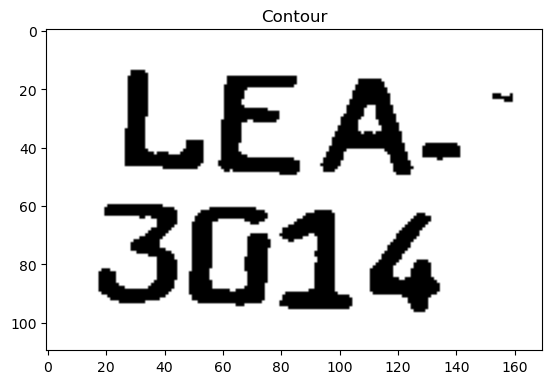

Two Rows


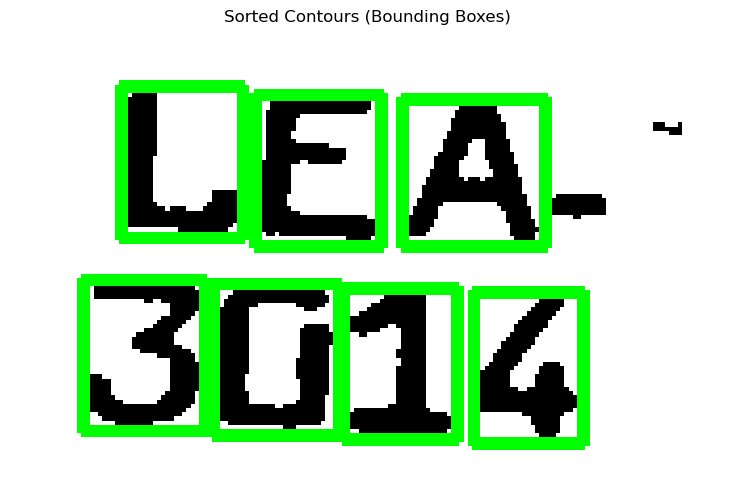

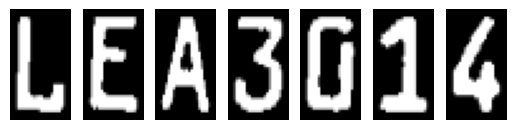

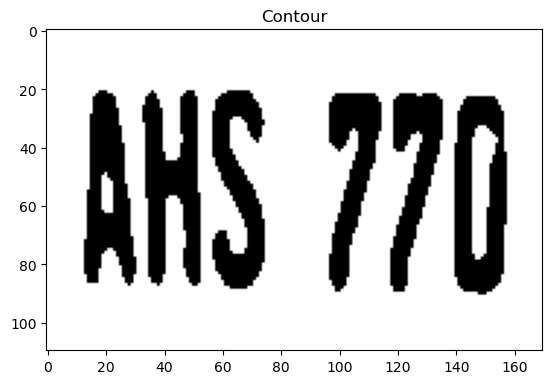

Single Row


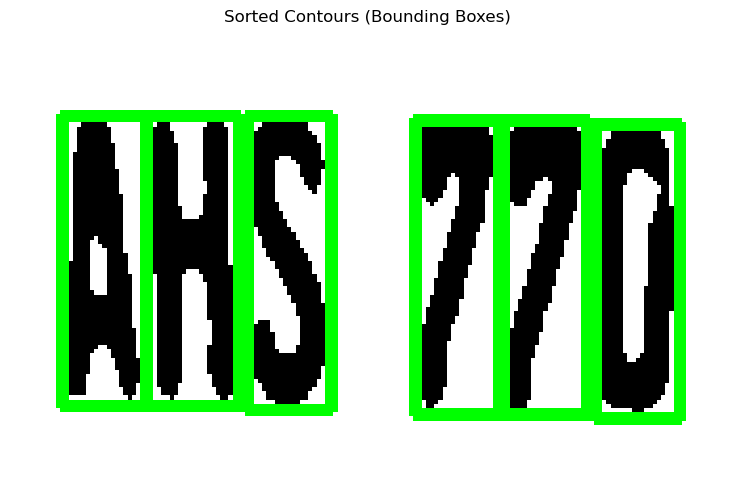

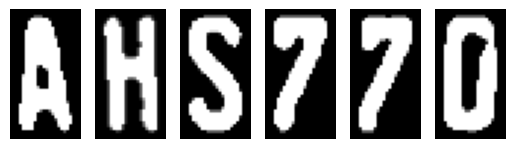

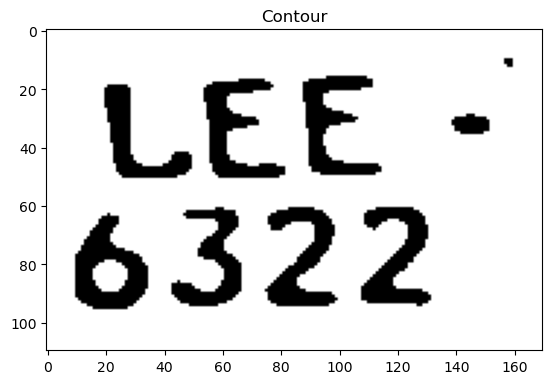

Two Rows


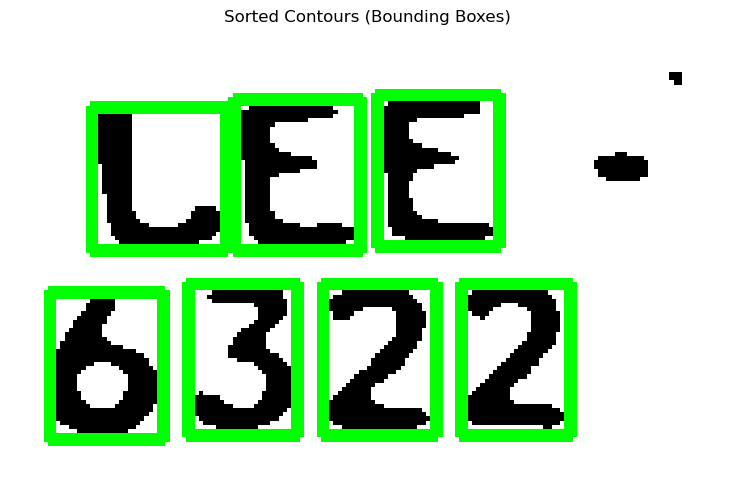

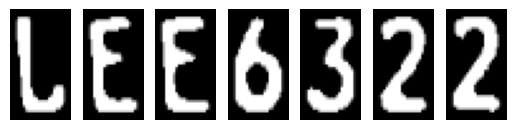

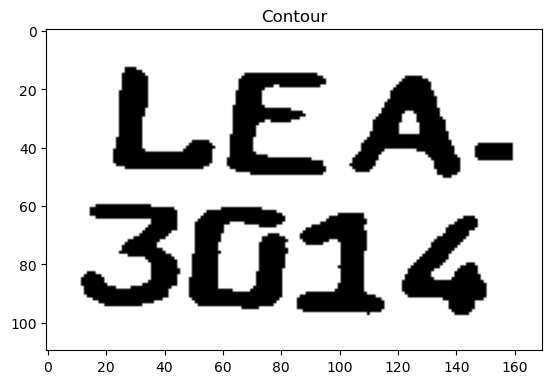

Two Rows


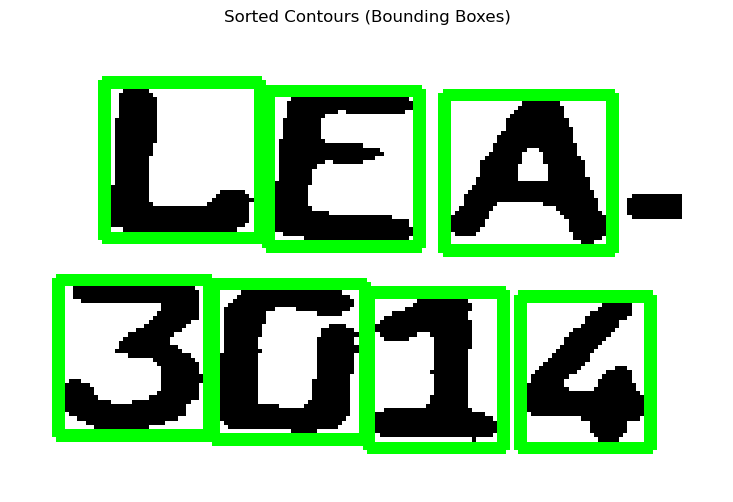

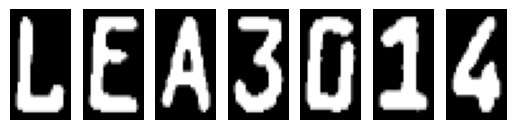

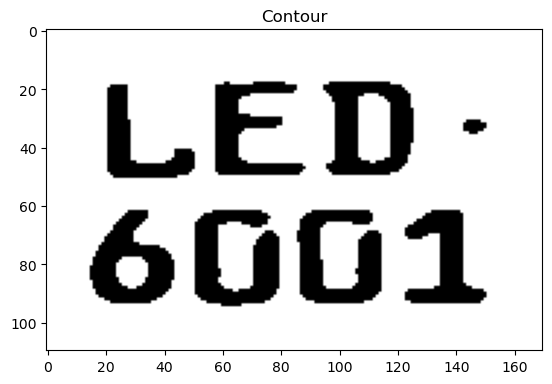

Two Rows


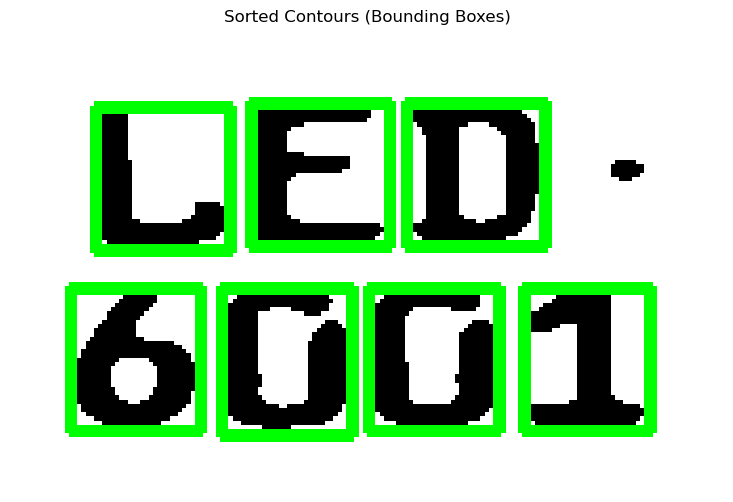

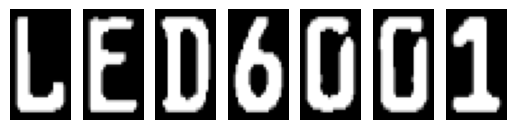

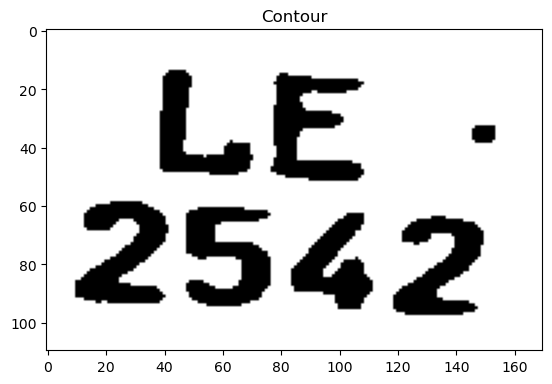

Two Rows


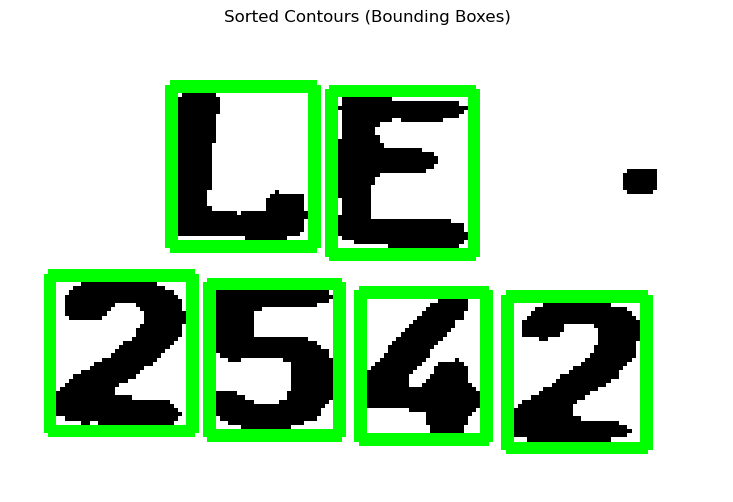

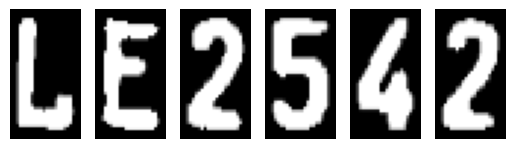

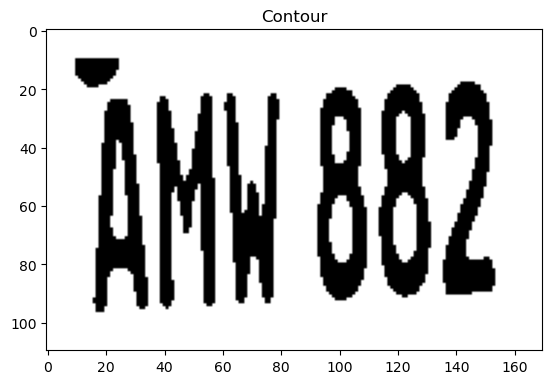

Single Row


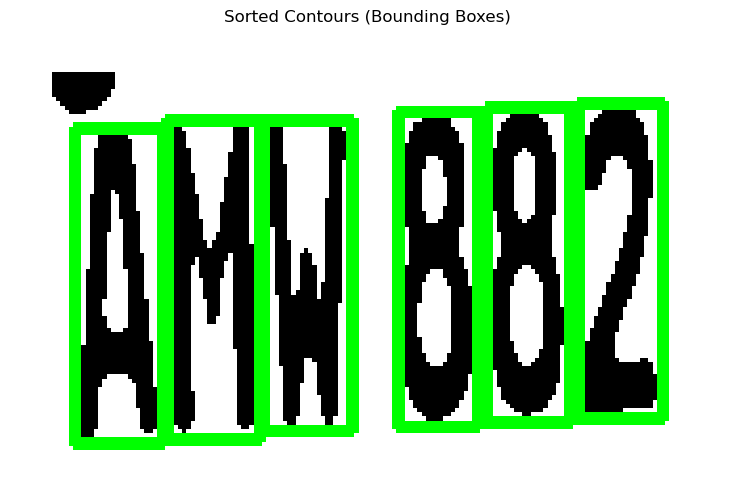

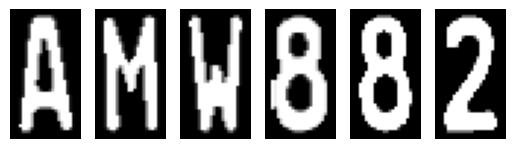

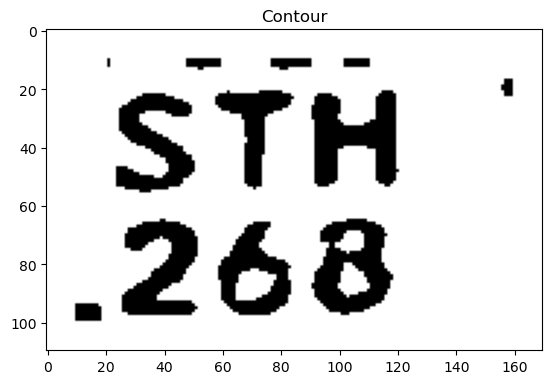

Two Rows


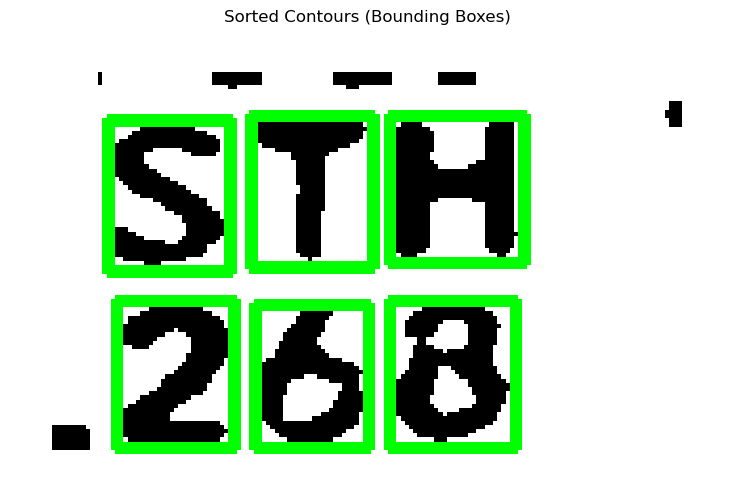

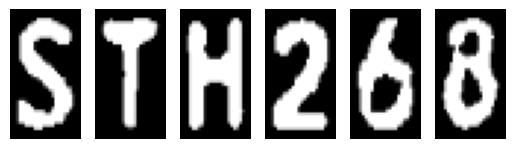

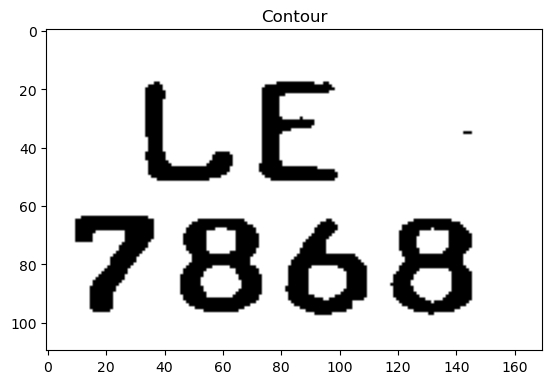

Two Rows


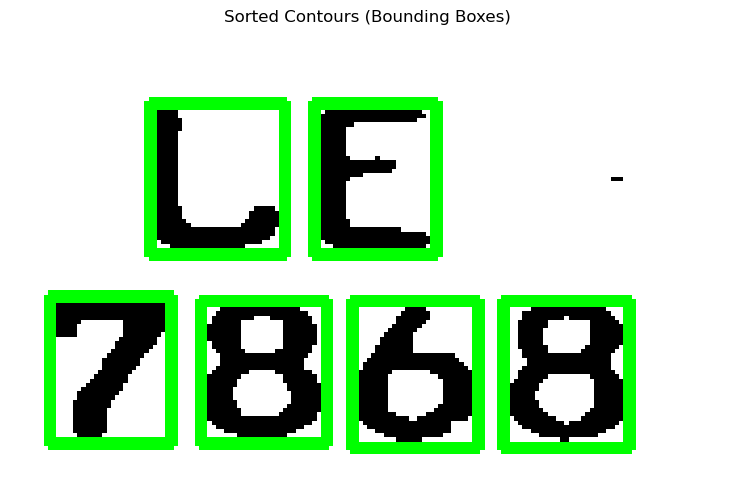

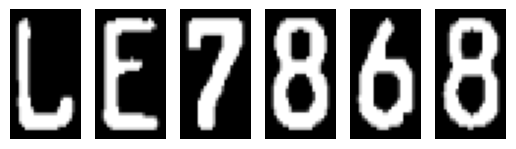

In [160]:
segmented_lps = []

for lp in x:
    segmented_characters = segment_characters(lp)
    segmented_lps.append(segmented_characters)

    for i, char in enumerate(segmented_characters):
        plt.subplot(1, len(segmented_characters), i + 1)
        plt.imshow(char, cmap='gray')
        plt.axis('off')
        
    plt.show()

In [161]:
print(len(segmented_lps))
print(type(segmented_lps[0]))
print(len(segmented_lps[0]))

for char in segmented_lps[0]:
    print(char.shape)

9
<class 'numpy.ndarray'>
7
(44, 24)
(44, 24)
(44, 24)
(44, 24)
(44, 24)
(44, 24)
(44, 24)


In [162]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)   # Output: 64 x 28 x 28
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) # Output: 128 x 14 x 14
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1) # Output: 256 x 7 x 7

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 3 * 3, 1024)  # Adjusted input size based on pooling
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 36)  # 36 classes (0-9 and A-Z)

        # Activation function
        self.relu = nn.ReLU()
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):

        x = self.relu(self.conv1(x))  # [64, 28, 28]
        x = self.pool(x)              # [64, 14, 14]

        x = self.relu(self.conv2(x))  # [128, 14, 14]
        x = self.pool(x)              # [128, 7, 7]

        x = self.relu(self.conv3(x))  # [256, 7, 7]
        x = self.pool(x)              # [256, 3, 3]

        x = x.view(x.size(0), -1)     # [256*3*3 = 2304]

        x = self.relu(self.fc1(x))    # [1024]
        x = self.dropout(x)            # Apply dropout

        x = self.relu(self.fc2(x))    # [512]
        x = self.dropout(x)            # Apply dropout

        x = self.fc3(x)                # [36]

        return x


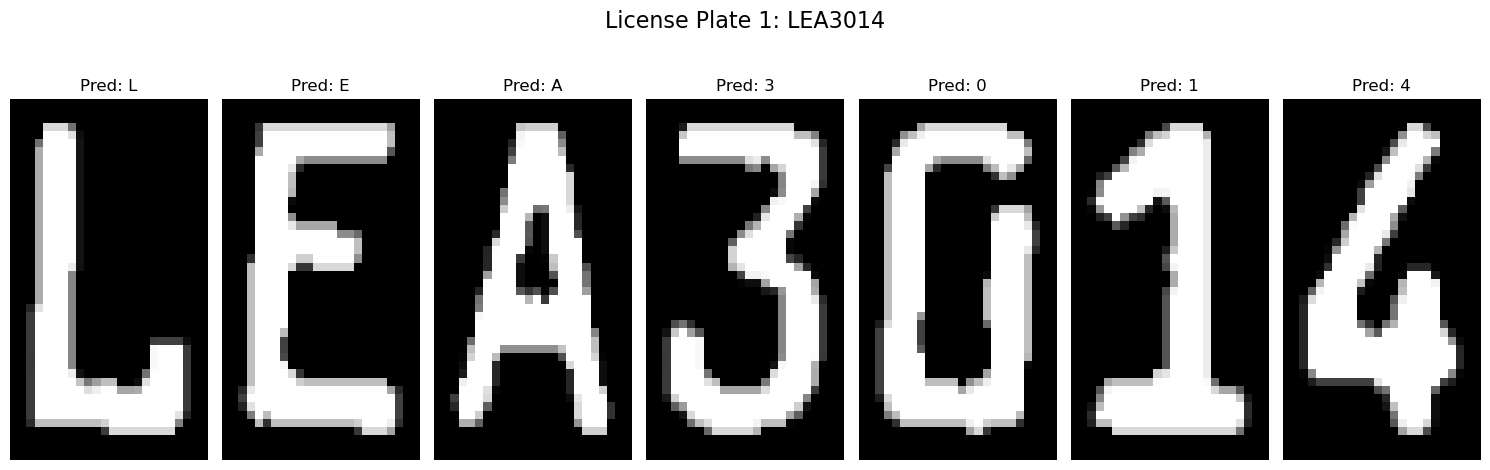

License Plate 1: LEA3014


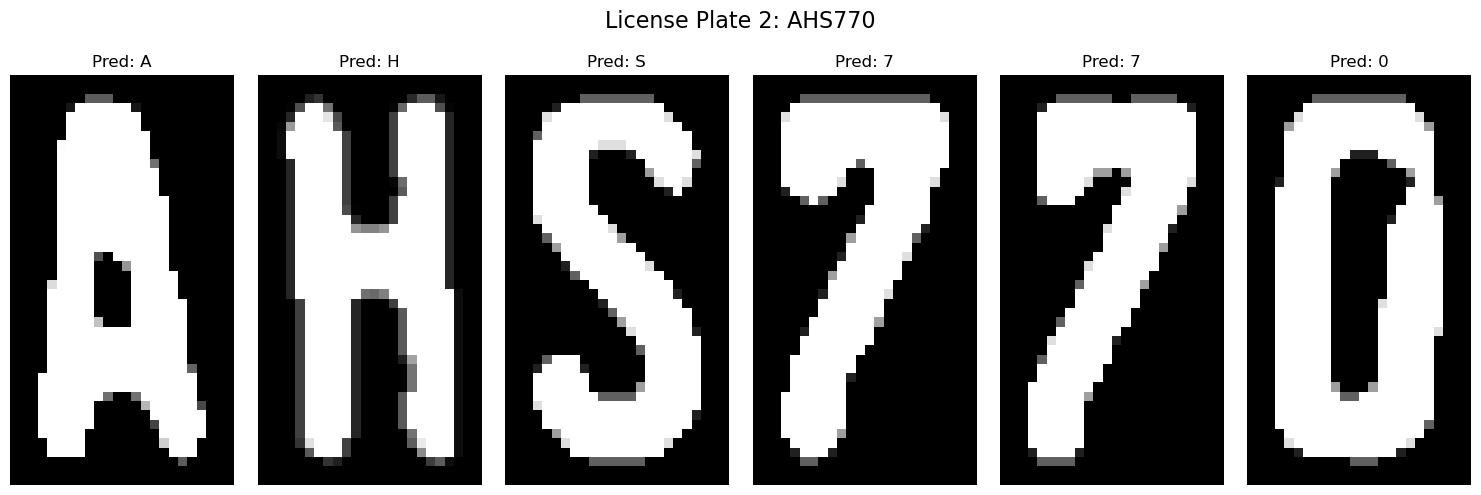

License Plate 2: AHS770


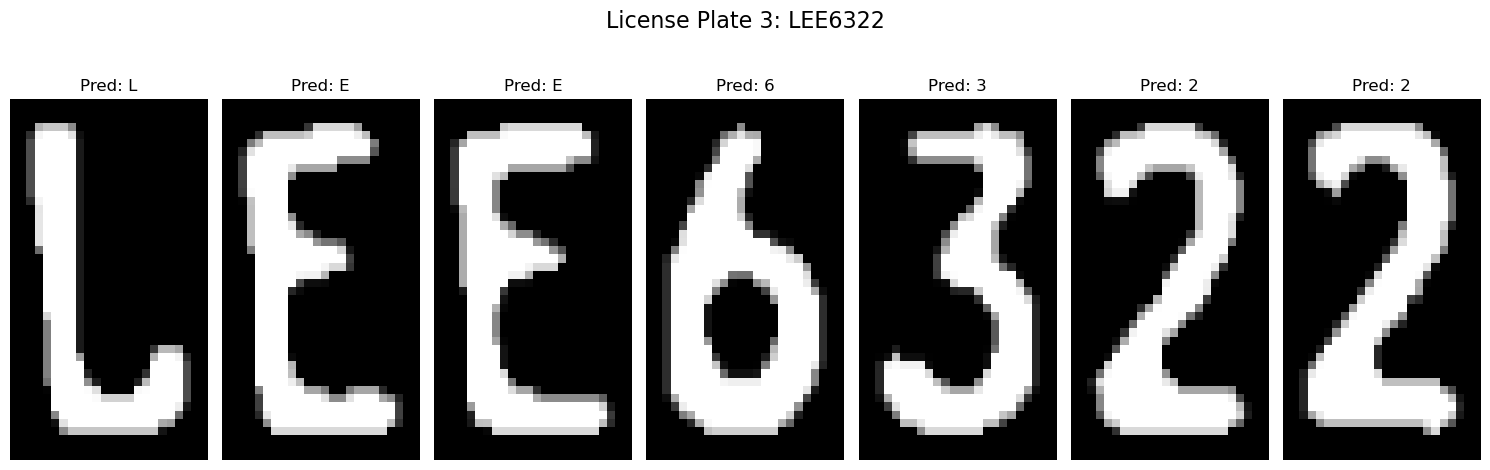

License Plate 3: LEE6322


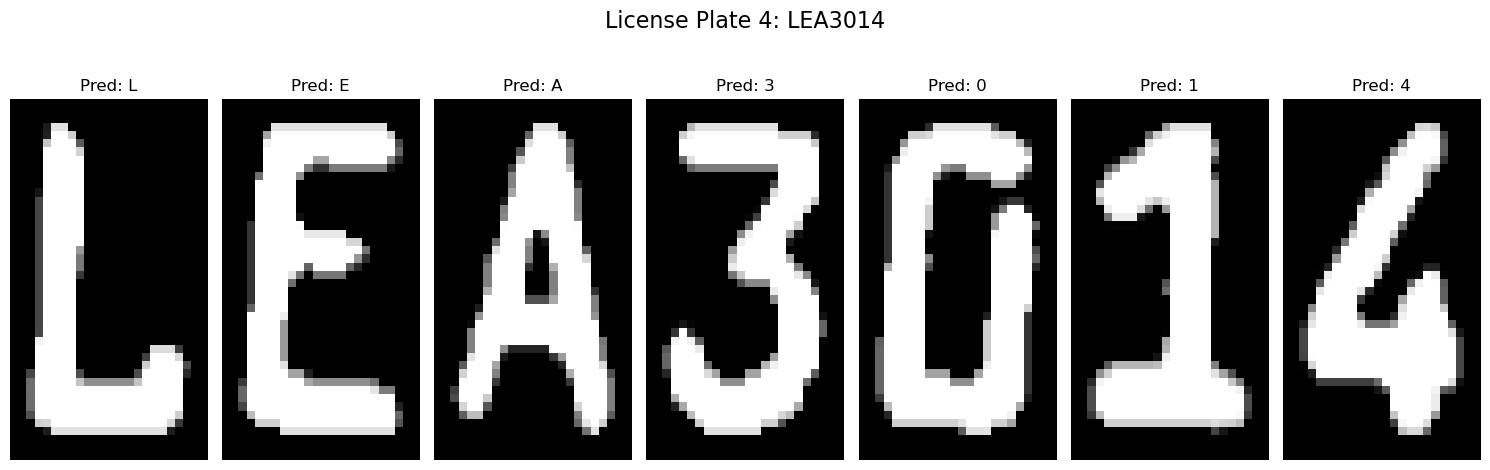

License Plate 4: LEA3014


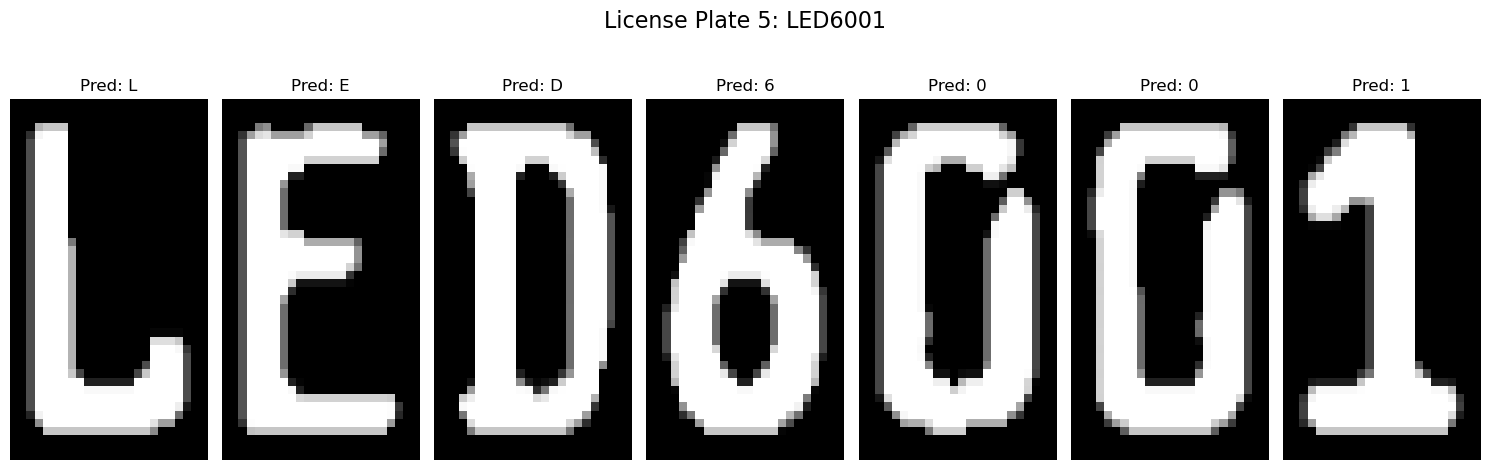

License Plate 5: LED6001


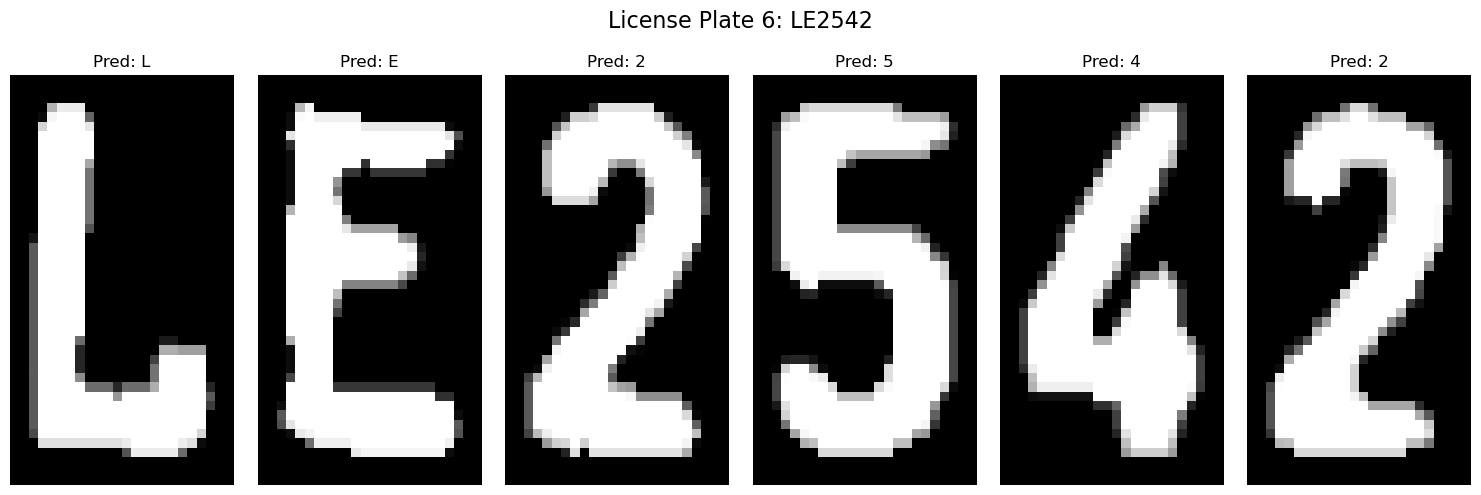

License Plate 6: LE2542


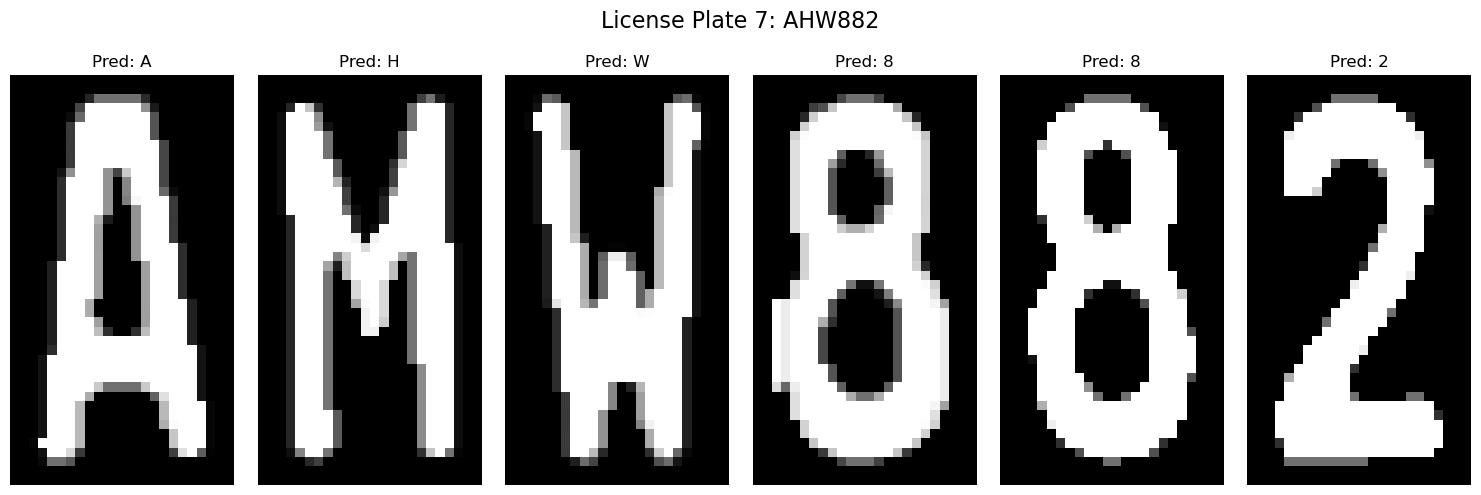

License Plate 7: AHW882


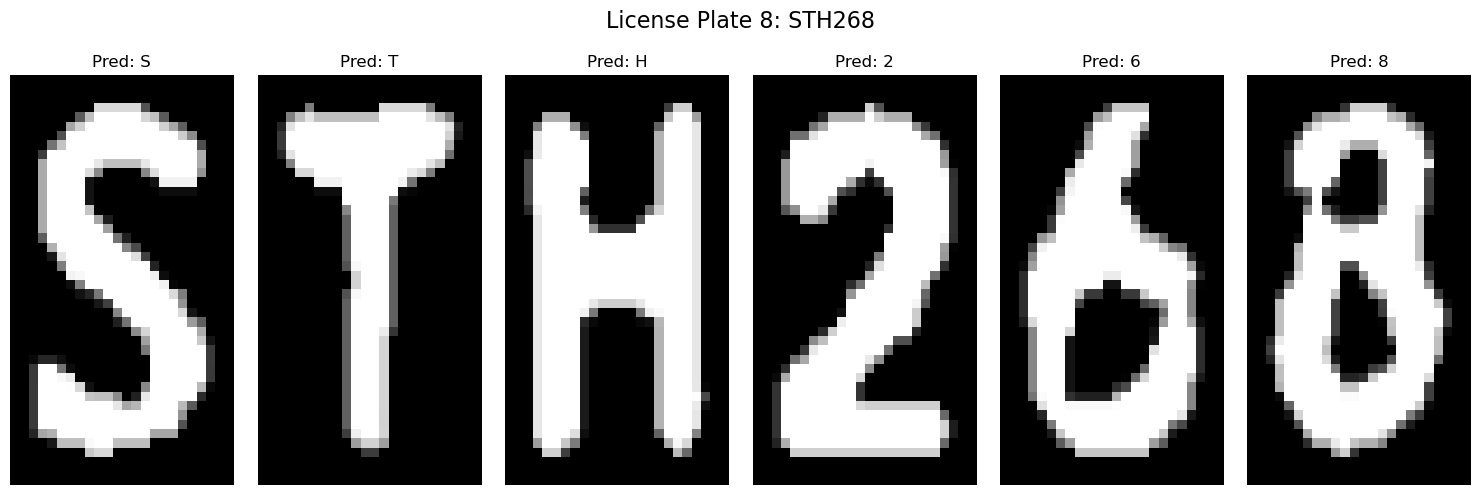

License Plate 8: STH268


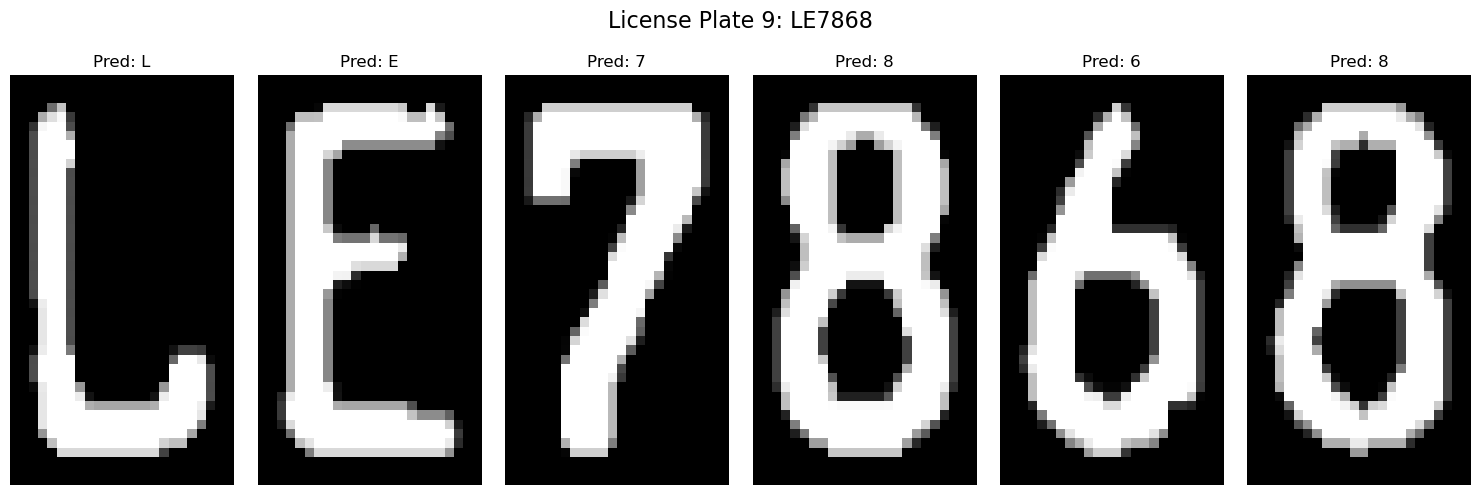

License Plate 9: LE7868


In [164]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'

model = torch.load('cnn.pth')
model.eval()

def preprocess_image(image):

    if image.mode != 'RGB':
        image = image.convert('RGB')

    transform = transforms.Compose([
        transforms.Resize((28, 28)),  
        transforms.ToTensor(),        
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  
    ])
    return transform(image).unsqueeze(0)  

for plate_idx, char_images in enumerate(segmented_lps):
    lp_number = ''
    predicted_classes = []  

    fig, axes = plt.subplots(1, len(char_images), figsize=(15, 5))

    for idx, char_image in enumerate(char_images):

        char_image_pil = Image.fromarray(char_image)

        img_tensor = preprocess_image(char_image_pil)

        with torch.no_grad():
            output_tensor = model(img_tensor)  
            predicted_class = output_tensor.argmax(dim=1).item()
            lp_number += characters[predicted_class]  
            predicted_classes.append(characters[predicted_class])  

        axes[idx].imshow(char_image_pil)
        axes[idx].set_title(f'Pred: {predicted_classes[-1]}')
        axes[idx].axis('off')

    plt.suptitle(f'License Plate {plate_idx + 1}: {lp_number}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

    print(f"License Plate {plate_idx + 1}: {lp_number}")


In [165]:
extracted_lp_numbers = []

for idx, char_images in enumerate(segmented_lps):
    lp_number = ''
    for char_image in char_images:

        char_image_pil = Image.fromarray(char_image)

        img_tensor = preprocess_image(char_image_pil)

        with torch.no_grad():
            output_tensor = model(img_tensor)  
            predicted_class = output_tensor.argmax(dim=1).item()  
            lp_number += characters[predicted_class]  

    print(f"License Plate {idx + 1}: {lp_number}")
    extracted_lp_numbers.append(lp_number)

License Plate 1: LEA3014
License Plate 2: AHS770
License Plate 3: LEE6322
License Plate 4: LEA3014
License Plate 5: LED6001
License Plate 6: LE2542
License Plate 7: AHW882
License Plate 8: STH268
License Plate 9: LE7868


In [166]:
print(extracted_lp_numbers)

['LEA3014', 'AHS770', 'LEE6322', 'LEA3014', 'LED6001', 'LE2542', 'AHW882', 'STH268', 'LE7868']


# Logging: 10 Marks

With the license plates successfully recognized, it’s time to finalize the operation by logging the critical information.

**Tasks:**

### Extract Timestamps:
**Objective:**
Identify and log the specific time and image label.

**Tasks:**
Develop a method to extract the image label and the timestamp corresponding to each detected license plate (time when entry was created in the database).
Ensure this information is accurately logged and associated with the correct license plate number for easy retrieval and reporting.



In [167]:
from datetime import datetime



0: 288x640 1 license_plate, 57.1ms
Speed: 3.4ms preprocess, 57.1ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 license_plate, 37.2ms
Speed: 0.9ms preprocess, 37.2ms inference, 0.3ms postprocess per image at shape (1, 3, 288, 640)


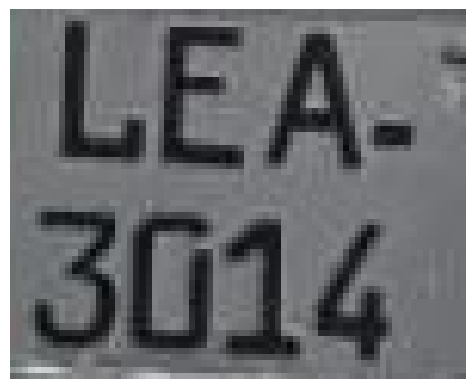

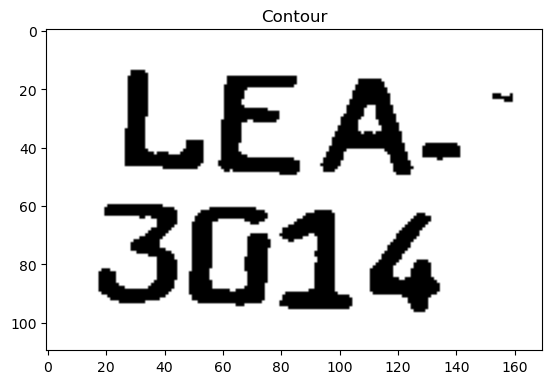

Two Rows


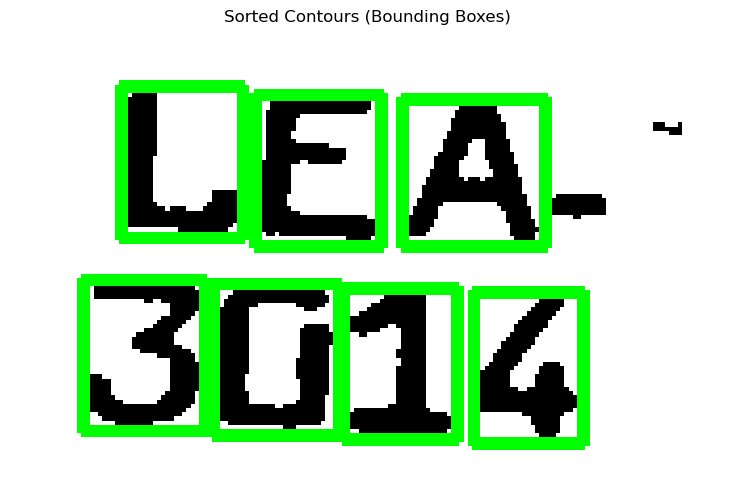

License Plate: LEA3014

0: 480x640 1 license_plate, 104.7ms
Speed: 2.3ms preprocess, 104.7ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 license_plate, 60.7ms
Speed: 1.7ms preprocess, 60.7ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)


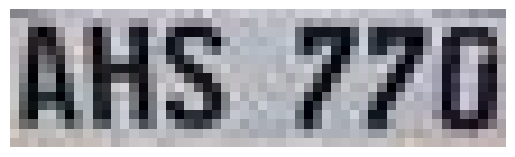

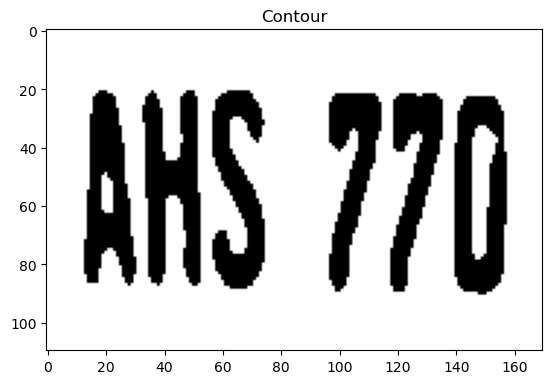

Single Row


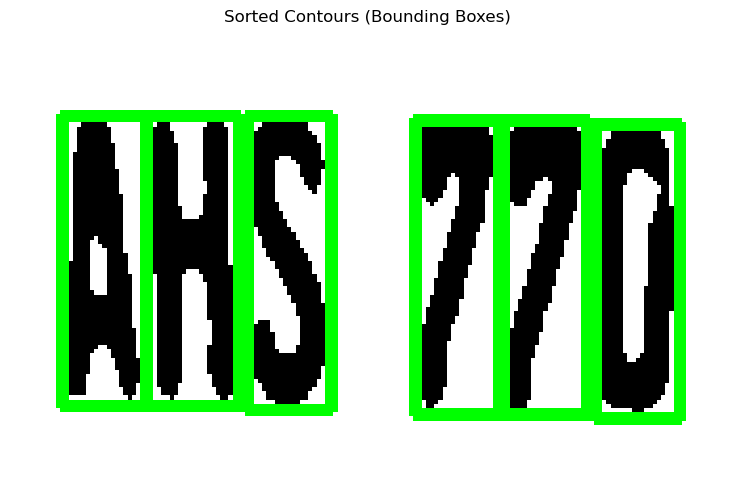

License Plate: AHS770

0: 608x640 1 license_plate, 119.6ms
Speed: 2.4ms preprocess, 119.6ms inference, 0.3ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 1 license_plate, 84.7ms
Speed: 1.8ms preprocess, 84.7ms inference, 0.3ms postprocess per image at shape (1, 3, 608, 640)


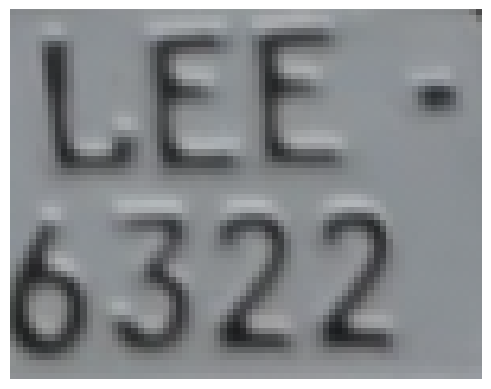

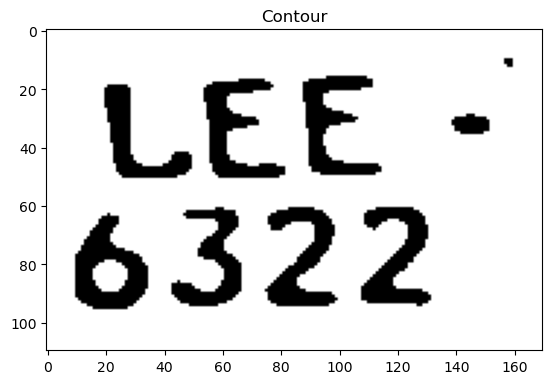

Two Rows


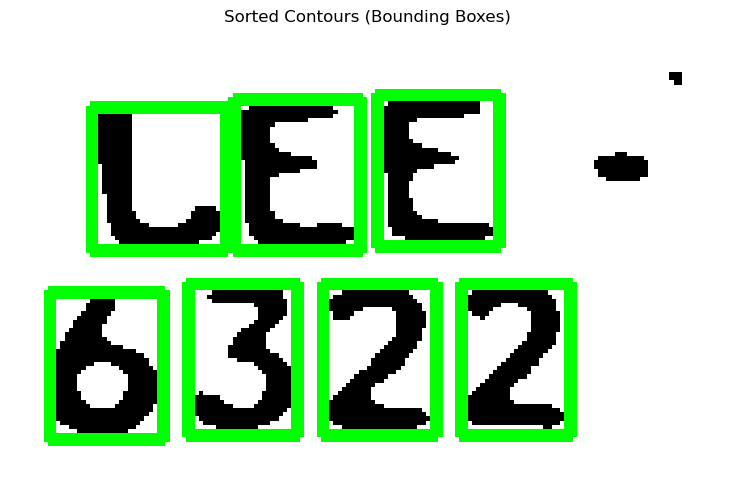

License Plate: LEE6322

0: 288x640 1 license_plate, 68.5ms
Speed: 36.5ms preprocess, 68.5ms inference, 0.3ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 license_plate, 54.4ms
Speed: 2.7ms preprocess, 54.4ms inference, 0.3ms postprocess per image at shape (1, 3, 288, 640)


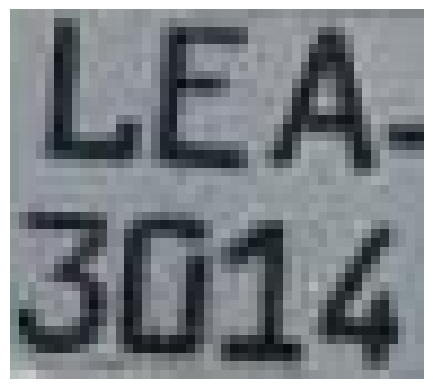

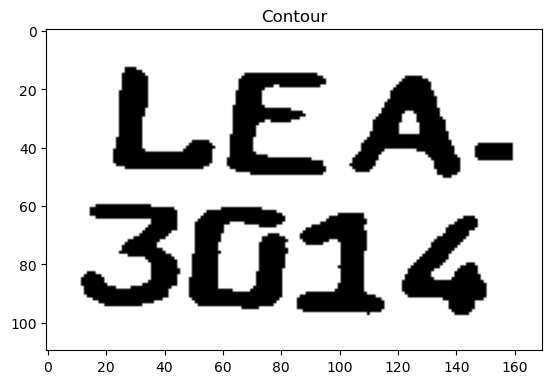

Two Rows


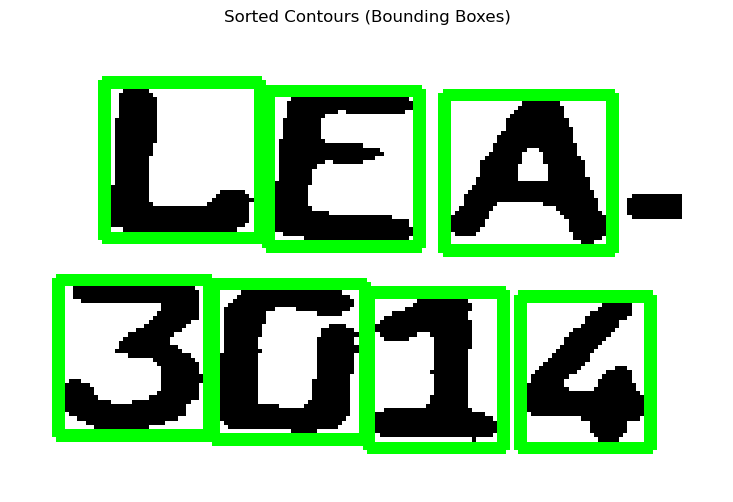

License Plate: LEA3014

0: 576x640 1 license_plate, 76.2ms
Speed: 3.1ms preprocess, 76.2ms inference, 0.3ms postprocess per image at shape (1, 3, 576, 640)

0: 576x640 1 license_plate, 74.4ms
Speed: 2.1ms preprocess, 74.4ms inference, 0.3ms postprocess per image at shape (1, 3, 576, 640)


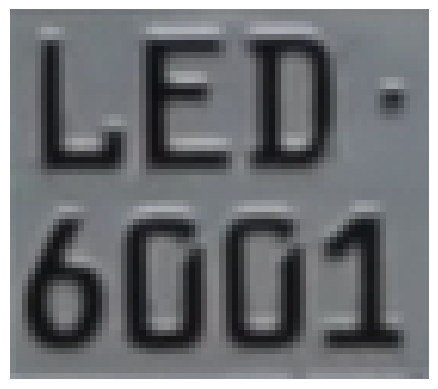

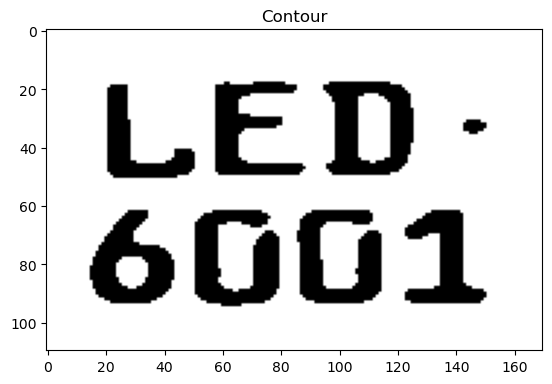

Two Rows


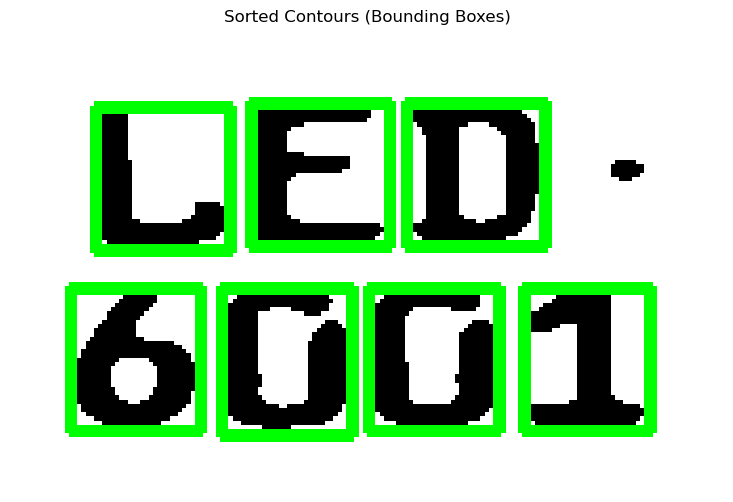

License Plate: LED6001

0: 640x384 1 license_plate, 99.6ms
Speed: 1.5ms preprocess, 99.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 license_plate, 52.9ms
Speed: 1.8ms preprocess, 52.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)


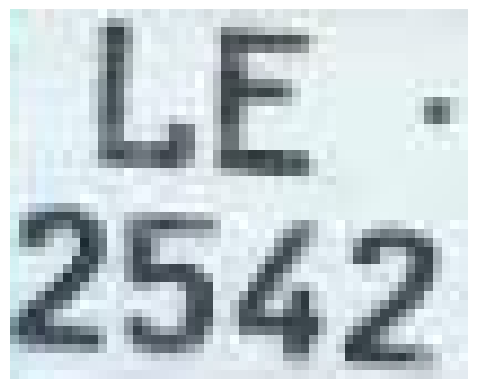

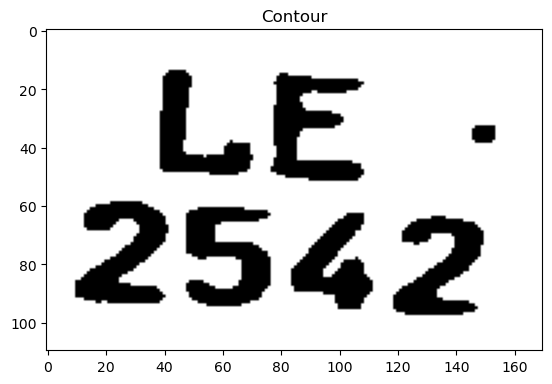

Two Rows


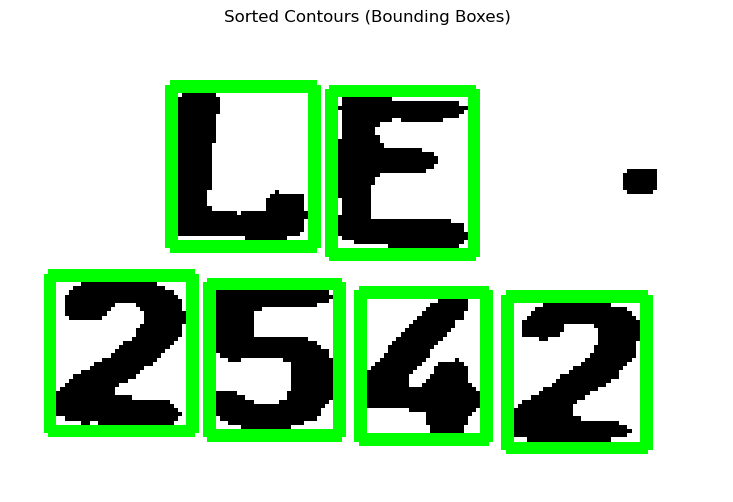

License Plate: LE2542

0: 608x640 1 license_plate, 102.1ms
Speed: 36.7ms preprocess, 102.1ms inference, 0.4ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 1 license_plate, 89.7ms
Speed: 2.1ms preprocess, 89.7ms inference, 0.3ms postprocess per image at shape (1, 3, 608, 640)


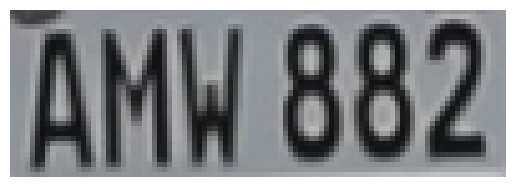

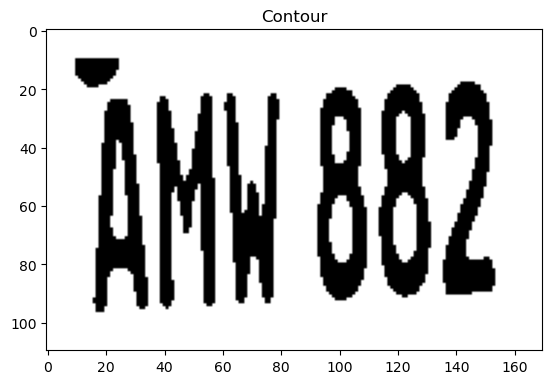

Single Row


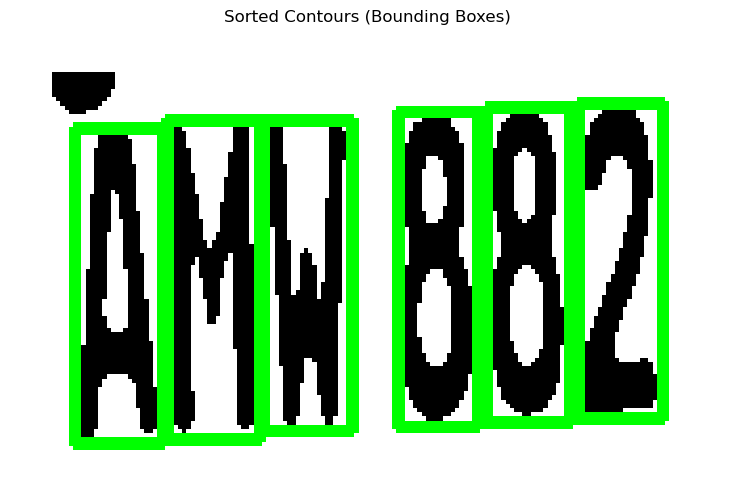

License Plate: AHW882

0: 640x288 1 license_plate, 63.3ms
Speed: 1.2ms preprocess, 63.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 1 license_plate, 83.1ms
Speed: 1.0ms preprocess, 83.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 288)


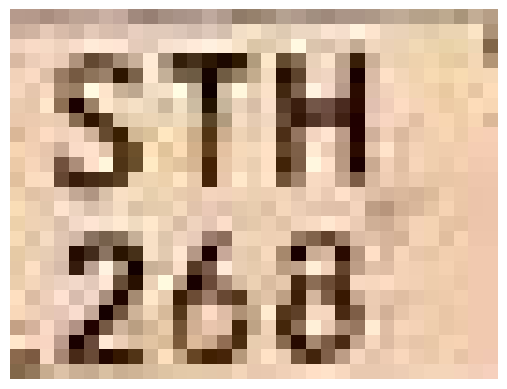

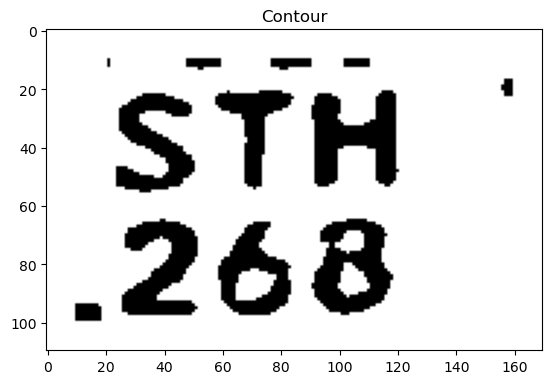

Two Rows


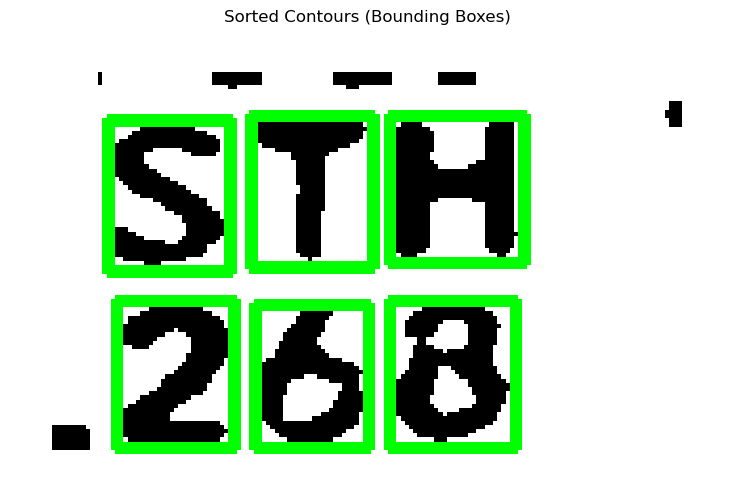

License Plate: STH268

0: 608x640 1 license_plate, 120.8ms
Speed: 10.1ms preprocess, 120.8ms inference, 0.3ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 1 license_plate, 75.5ms
Speed: 1.9ms preprocess, 75.5ms inference, 0.3ms postprocess per image at shape (1, 3, 608, 640)


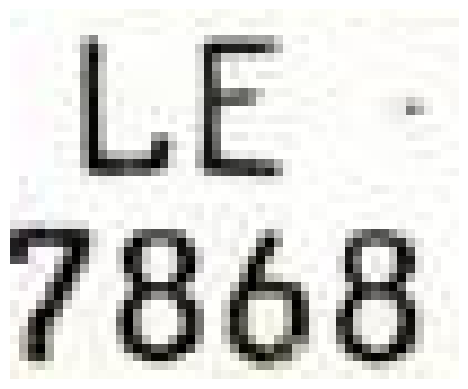

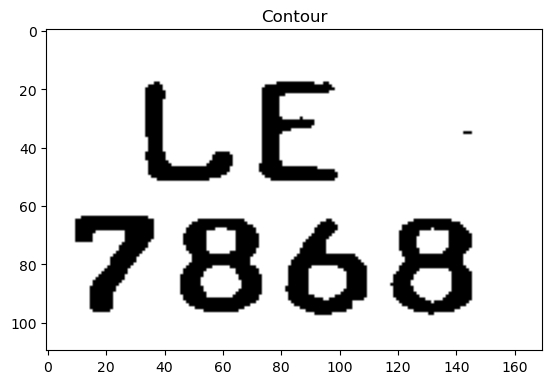

Two Rows


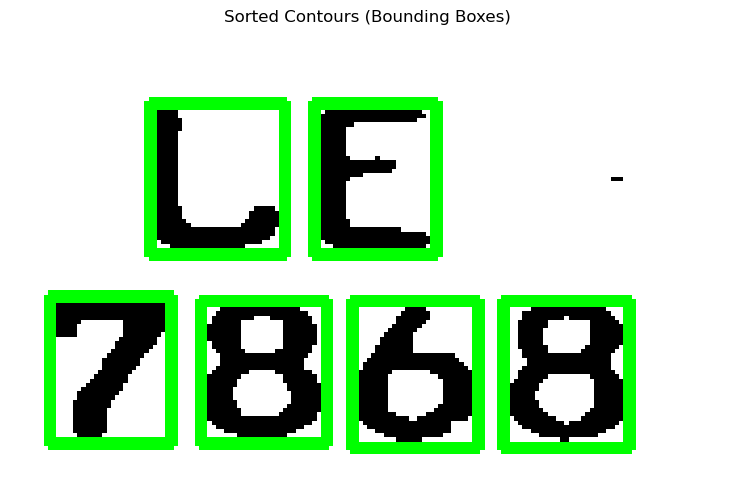

License Plate: LE7868
Logged 9 entries to license_plate_database.csv.


In [170]:
output_csv = 'license_plate_database.csv'
characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
log_entries = []
i = 0

for file in os.listdir('car_images'):

    if file.lower().endswith(('.jpg', '.jpeg', '.png')):

        img_path = os.path.join('car_images', file)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        filename = file

        detected_lp = detect_license_plate(img_rgb, save_output=False)
        cropped_lp = crop_image(detected_lp, zoom_factor=0.1)
        adjusted_lp = crop_adjustment(cropped_lp[0], crop_mat[i][0], crop_mat[i][1], crop_mat[i][2], crop_mat[i][3])
        segments = segment_characters(adjusted_lp)
        lp = ''

        for char_image in segments:

            char_image_pil = Image.fromarray(char_image)
            img_tensor = preprocess_image(char_image_pil)

            with torch.no_grad():
                output_tensor = model(img_tensor)
                predicted_class = output_tensor.argmax(dim=1).item()
                lp += characters[predicted_class]

        print(f"License Plate: {lp}")

        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        log_entries.append({
            'License Plate': lp,
            'Image Label': filename,
            'Timestamp': timestamp
        })

        i += 1


# Generate a database entry (inn a CSV file) containing the car license number, image label (e.g., img1.png or img2.jpg), and
#the timestamp of when the entry is created.
log_df = pd.DataFrame(log_entries)
log_df.to_csv(output_csv, index=False)

print(f"Logged {len(log_entries)} entries to {output_csv}.")

# Streamlit Integration and Safe City Deployment: 15 Marks

Agent, your final task is to integrate all your hard work into a user-friendly application that can be deployed in the real world. With Safe City cameras employed everywhere, your Streamlit application will play a crucial role in maintaining security across the city. This mission will require you to develop a streamlined web application that automatically recognizes license plates from uploaded images and logs the data for easy access and analysis.

**Tasks:**

### Streamlit Web Application Development:

Create a simple, yet effective, web application using Streamlit that integrates your previous work into a cohesive system.

Develop a Streamlit application allowing users to enter car license numbers and generate car images with corresponding timestamps.



In [174]:
# run "streamlit run app.py" in terminal to run the app

# Assessment Criteria: Operation Detective Vision

As you complete the mission, your work will be assessed based on the following key criteria:

## Technical Competence:

**Effectiveness:** How well does your system perform in terms of recognizing and logging license plates? Are the results accurate and reliable?

**Integration:** How seamlessly have you integrated all components of the project into the final Streamlit application? Is the user interface intuitive and user-friendly?
